In [44]:
# Importar Bibliotecas
import requests
import zipfile
import io
import os
import pandas as pd
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [51]:
# Importar cotação do dólar
def fetch_currency_data(start_date, end_date, currency_code):
    url = f'https://api.bcb.gov.br/dados/serie/bcdata.sgs.{currency_code}/dados?formato=json&dataInicial={start_date}&dataFinal={end_date}'
    try:
        response = requests.get(url)
        response.raise_for_status()  # Lança exceção se a resposta não for bem-sucedida
        data = response.json()
        
        # Verifica se há dados retornados pela API
        if not data:
            print("Não foram encontrados dados para o período especificado.")
            return None
        
        # Criando listas para as colunas 'data' e 'valor'
        dates = []
        values = []
        
        # Iterando sobre os dados para extrair 'data' e 'valor'
        for entry in data:
            dates.append(pd.to_datetime(entry['data'], dayfirst=True))
            values.append(float(entry['valor'].replace(',', '.')))  # Converte para float
        
        # Criando o DataFrame com 'data' como coluna regular (não índice)
        df = pd.DataFrame({'data': dates, 'valor': values})
        
        return df
    
    except requests.exceptions.RequestException as e:
        print(f"Erro ao recuperar os dados: {e}")
        return None

# Definindo o período dos últimos 5 anos
end_date = pd.Timestamp.now().strftime('%d/%m/%Y')
start_date = (pd.Timestamp.now() - pd.DateOffset(years=5)).strftime('%d/%m/%Y')

# Código do dólar no Banco Central é 1 (Código da série de cotação do dólar)
currency_code = 1

# Chamando a função para buscar os dados
df_dollar = fetch_currency_data(start_date, end_date, currency_code)

if df_dollar is not None:
    # Exibindo os últimos registros para verificar se os dados foram importados corretamente
    print(df_dollar.tail())
else:
    print("Não foi possível obter os dados da cotação do dólar.")


           data   valor
1250 2024-06-06  5.2681
1251 2024-06-07  5.2802
1252 2024-06-10  5.3666
1253 2024-06-11  5.3524
1254 2024-06-12  5.3891


In [ ]:
# Function to create directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Directory where files will be saved
save_directory = "combustivel_data"
create_directory(save_directory)

# URLs to download
urls = [
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2023-02.zip",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2023-01.zip",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2022-02.zip",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/precos-semestrais-ca.zip",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2021-02.csv",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2021-01.csv",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2020-02.csv",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2020-01.csv",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2019-02.csv",
    "https://www.gov.br/anp/pt-br/centrais-de-conteudo/dados-abertos/arquivos/shpc/dsas/ca/ca-2019-01.csv",
    # Add more URLs here
]

for url in urls:
    # Check if the URL is valid
    if not url.startswith("http"):
        print(f"Invalid URL '{url}'. Skipping...")
        continue
    
    try:
        # Send a GET request to the URL
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Determine if the URL points to a CSV or ZIP file
            if url.endswith('.csv'):
                # Save the CSV file directly
                csv_filename = os.path.join(save_directory, os.path.basename(url))
                with open(csv_filename, 'wb') as csv_file:
                    csv_file.write(response.content)
                print(f"CSV file '{csv_filename}' downloaded successfully from '{url}'.")
            elif url.endswith('.zip'):
                # Read the content of the response
                zip_content = response.content

                # Create a BytesIO object from the zip content
                zip_file = io.BytesIO(zip_content)

                # Extract the zip file
                with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                    # Get the list of files in the zip
                    file_list = zip_ref.namelist()

                    # Find the CSV file in the zip
                    csv_files = [file for file in file_list if file.endswith('.csv')]

                    # Check if CSV files were found
                    if csv_files:
                        for csv_file in csv_files:
                            # Extract the CSV file to the save directory
                            zip_ref.extract(csv_file, save_directory)
                            print(f"CSV file '{csv_file}' extracted successfully from '{url}' to '{save_directory}'.")
                    else:
                        print(f"No CSV file found in the zip from '{url}'.")
            else:
                print(f"Unsupported file type for URL '{url}'.")
        else:
            print(f"Error {response.status_code} for URL '{url}'.")
    except requests.exceptions.RequestException as e:
        print(f"Request failed for URL '{url}': {e}")

In [30]:
# Juntar todos os arquivos CSV em um único arquivo

# Directory containing the CSV files
folder_path = 'combustivel_data'

# List all files in the directory
files = os.listdir(folder_path)

# Filter only CSV files
csv_files = [file for file in files if file.endswith('.csv')]

# Initialize an empty list to store dataframes
dfs = []

# Read each CSV file and append to the list
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path, sep=';', encoding='latin-1')
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined dataframe to a new CSV file
combined_file_path = os.path.join(folder_path, 'combustivel_data_resume.csv')
combined_df.to_csv(combined_file_path, index=False)

print(f"Combined CSV file saved at: {combined_file_path}")



/var/folders/m8/jkvf92lx63b_ngyfvsyx2zdr0000gn/T/ipykernel_13558/285897740.py:18: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=';', encoding='latin-1')


Combined CSV file saved at: combustivel_data/combustivel_data_resume.csv


In [31]:
# Cria um arquivo apenas com os dados de interesse (Estado - Sigla,Produto,Data da Coleta,Valor de Venda,Valor de Compra)

# File path of the combined CSV file
combined_file_path = 'combustivel_data/combustivel_data_resume.csv'

# Columns to keep in the new CSV file
columns_to_keep = ['Estado - Sigla', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra']

# Read the combined CSV file into a dataframe
combined_df = pd.read_csv(combined_file_path)

# Select only the columns of interest
selected_columns_df = combined_df[columns_to_keep]

# File path to save the filtered CSV file
filtered_file_path = 'combustivel_data/combustivel_data_filtered.csv'

# Save the filtered dataframe to a new CSV file
selected_columns_df.to_csv(filtered_file_path, index=False)

print(f"Filtered CSV file saved at: {filtered_file_path}")

/var/folders/m8/jkvf92lx63b_ngyfvsyx2zdr0000gn/T/ipykernel_13558/3222378880.py:10: DtypeWarning: Columns (0,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv(combined_file_path)


Filtered CSV file saved at: combustivel_data/combustivel_data_filtered.csv


In [40]:
# Cria um csv com os valores medios diarios

# File path of the filtered CSV file
filtered_file_path = 'combustivel_data/combustivel_data_filtered.csv'

# Read the filtered CSV file into a dataframe
filtered_df = pd.read_csv(filtered_file_path)

# Convert 'Data da Coleta' to datetime format with correct format
filtered_df['Data da Coleta'] = pd.to_datetime(filtered_df['Data da Coleta'], format='%d/%m/%Y')

# Replace comma with dot in numeric columns and convert to numeric type
filtered_df['Valor de Venda'] = filtered_df['Valor de Venda'].str.replace(',', '.').astype(float)
filtered_df['Valor de Compra'] = filtered_df['Valor de Compra'].str.replace(',', '.').astype(float)

# Calculate average prices per day
average_prices_per_day = filtered_df.groupby('Data da Coleta').agg({
    'Valor de Venda': 'mean',
    'Valor de Compra': 'mean'
}).reset_index()

# File path to save the average prices per day CSV file
average_prices_file_path = 'combustivel_data/average_prices_per_day.csv'

# Save the average prices per day dataframe to a new CSV file
average_prices_per_day.to_csv(average_prices_file_path, index=False)

print(f"Average prices per day CSV file saved at: {average_prices_file_path}")

/var/folders/m8/jkvf92lx63b_ngyfvsyx2zdr0000gn/T/ipykernel_13558/3882960345.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = pd.read_csv(filtered_file_path)


Average prices per day CSV file saved at: combustivel_data/average_prices_per_day.csv


In [41]:
# Converter o csv para um dataframe

# File path of the average prices per day CSV file
average_prices_file_path = 'combustivel_data/average_prices_per_day.csv'

# Read the CSV file into a dataframe
average_prices_per_day_df = pd.read_csv(average_prices_file_path)

# Display the dataframe to verify
print(average_prices_per_day_df.head())

  Data da Coleta  Valor de Venda  Valor de Compra
0     2019-01-02        3.656707         3.175921
1     2019-01-03        3.657614         3.190422
2     2019-01-04        4.147833         3.377800
3     2019-01-07        3.628287         3.112941
4     2019-01-08        3.629233         3.153689


Index(['data', 'valor'], dtype='object')


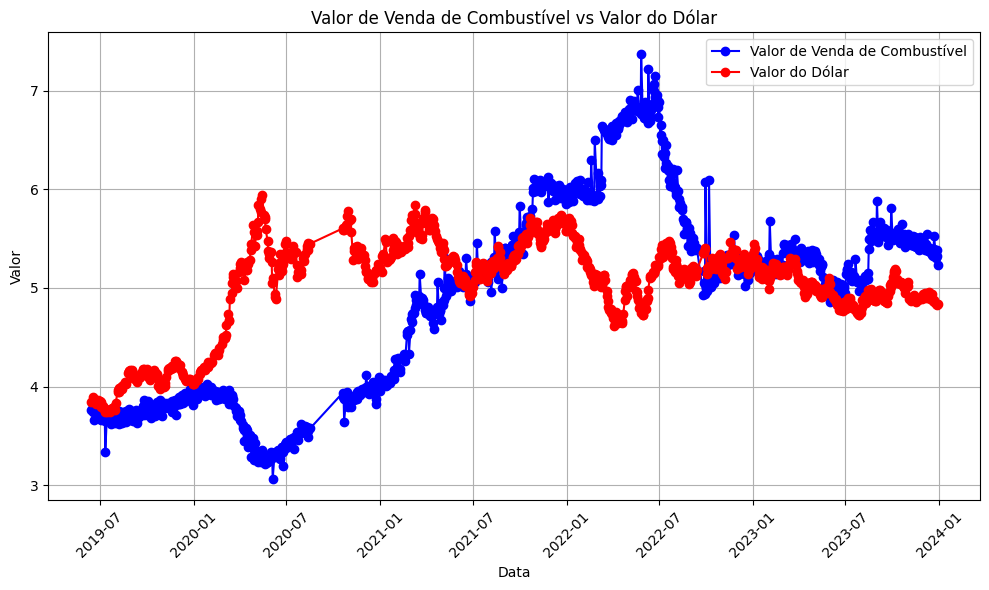

In [52]:
#grafico de relação entre o valor de venda do combustivel e o valor do dolar

# Converter as colunas de data para o tipo datetime
average_prices_per_day_df['Data da Coleta'] = pd.to_datetime(average_prices_per_day_df['Data da Coleta'])
print(df_dollar.keys())
df_dollar['data'] = pd.to_datetime(df_dollar['data'])

# Merge dos dataframes pelo campo de data
df_merged = pd.merge(average_prices_per_day_df, df_dollar, left_on='Data da Coleta', right_on='data')

# Plotar o gráfico
plt.figure(figsize=(10, 6))

# Linha para o Valor de Venda do combustível
plt.plot(df_merged['Data da Coleta'], df_merged['Valor de Venda'], marker='o', linestyle='-', color='b', label='Valor de Venda de Combustível')

# Linha para o valor do dólar
plt.plot(df_merged['Data da Coleta'], df_merged['valor'], marker='o', linestyle='-', color='r', label='Valor do Dólar')

# Definir título e rótulos dos eixos
plt.title('Valor de Venda de Combustível vs Valor do Dólar')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()